In [23]:
# Essential imports for deep learning and visualization
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

# Data science and visualization libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")

if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("   Running on CPU")

print(f"\n📦 Library Versions:")
print(f"   PyTorch: {torch.__version__}")
print(f"   NumPy: {np.__version__}")
print(f"   Matplotlib: {plt.matplotlib.__version__}")

print("\n✅ Environment setup complete!")

ModuleNotFoundError: No module named 'sklearn'

In [24]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size=784, hidden1_size=256, hidden2_size=128, hidden3_size=64, num_classes=10):
        super(MultiLayerPerceptron, self).__init__()

        #Network Layer
        self.flatten = nn.Flatten() #Flatten 2D/3D image to 1D tensor
        self.hidden1 = nn.Linear(input_size, hidden1_size)
        self.hidden2 = nn.Linear(hidden1_size, hidden2_size)
        self.hidden3 = nn.Linear(hidden2_size, hidden3_size)
        self.output = nn.Linear(hidden3_size, num_classes)

        #Activation Function
        self.relu = nn.ReLU()

        #Droput for regularization
        self.dropout = nn.Dropout(p=0.25)

         #Store Architecture Info
        self.input_size = input_size
        self.hidden1_size = hidden1_size
        self.hidden2_size = hidden2_size
        self.hidden3_size = hidden3_size
        self.num_classes = num_classes

        '''
        Alternative Formulation:
        
        self.model = nn.Sequential(
            nn.Flatten(),                     # 1×28×28 → 784
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(64, num_classes)
        )
        
        and use it in forward pass like
        
        return self.model(X) '''

    def forward(self, X):
        #X: Input tensor of shape (batch_size, 1, 28, 28)
        #returns: logits: Output tensor of shape (batch_size, num_classes)

        X = self.flatten(X)

        #Hidden Layer 1: 784 -> 256
        X = self.hidden1(X)
        X = self.relu(X)
        X = self.dropout(X)

        #Hidden Layer 2: 256 -> 128
        X = self.hidden2(X)
        X = self.relu(X)
        X = self.dropout(X)

        #Hidden Layer 3: 128 -> 64
        X = self.hidden3(X)
        X = self.relu(X)
        X = self.dropout(X)

        #Output Logits: 64 -> 10
        logits = self.output(X)

        return logits

    def info(self):
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        info = {
            'Architecture': f'{self.input_size} -> {self.hidden1_size} -> {self.hidden2_size} -> {self.num_classes}',
            'Total Parameters': f'{total_params:,}',
            'Trainable Parameters': f'{trainable_params:,}',
            'Model Size (MB)': f'{total_params * 4 / (1024**2):.2f}',  # Assuming float32
        }
        return info

    def visualize(model):
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
        # Extract hidden layers
        hidden_layers = [
            module for name, module in model.named_children()
            if isinstance(module, torch.nn.Linear) and name != "output"
        ]
        num_hidden = len(hidden_layers)
    
        # Define layer sizes
        input_size = getattr(model, "input_size", None)
        num_classes = getattr(model, "num_classes", None)
    
        if input_size is None or num_classes is None:
            raise ValueError("Model must have 'input_size' and 'num_classes' attributes")
    
        layers = [f"Input\n({input_size})"]
        layer_sizes = [input_size]
        positions = [0]
    
        for i in range(1, num_hidden + 1):
            layer_size = getattr(model, f"hidden{i}_size", None)
            if layer_size:
                layers.append(f"Hidden {i}\n({layer_size})")
                layer_sizes.append(layer_size)
                positions.append(i)
    
        layers.append(f"Output\n({num_classes})")
        layer_sizes.append(num_classes)
        positions.append(num_hidden + 1)
    
        # Plot as rectangles
        for i, (pos, size, label) in enumerate(zip(positions, layer_sizes, layers)):
            height = np.log10(size + 1) * 0.5
            rect = plt.Rectangle(
                (pos - 0.1, -height / 2), 0.2, height,
                facecolor='lightblue', edgecolor='black', linewidth=2
            )
            ax.add_patch(rect)
    
            # Add layer labels
            ax.text(pos, height / 2 + 0.2, label, ha='center', va='bottom',
                    fontweight='bold', fontsize=12)
    
            # Add activation labels
            if i < len(layers) - 1:  # not for output layer
                activation = 'ReLU' if i < len(layers) - 2 else 'Softmax'
                ax.text(pos + 0.5, 0, activation, ha='center', va='center',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7),
                        fontsize=10)
    
            # Draw connections
            if i < len(layers) - 1:
                next_height = np.log10(layer_sizes[i + 1] + 1) * 0.5
                for j in range(5):
                    y_start = height / 2 - j * (height / 4)
                    y_end = next_height / 2 - j * (next_height / 4)
                    ax.arrow(pos + 0.1, y_start,
                             0.8, y_end - y_start,
                             head_width=0.05, head_length=0.05,
                             fc='gray', ec='gray', alpha=0.6, length_includes_head=True)
    
        # Styling
        ax.set_xlim(-0.5, positions[-1] + 0.5)
        ax.set_ylim(-2, 2)
        ax.set_title('Multi-Layer Perceptron Architecture', fontsize=16, fontweight='bold', pad=20)
        ax.axis('off')
    
        plt.tight_layout()
        plt.show()


In [25]:
model = MultiLayerPerceptron().to(device)
print(f'Model Architecture')
print(model)

Model Architecture
MultiLayerPerceptron(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden1): Linear(in_features=784, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=128, bias=True)
  (hidden3): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)


In [26]:
model_info = model.info()
print(f"\n Model Statistics")
for key, value in model_info.items():
    print(f"    {key}: {value}")


 Model Statistics
    Architecture: 784 -> 256 -> 128 -> 10
    Total Parameters: 242,762
    Trainable Parameters: 242,762
    Model Size (MB): 0.93


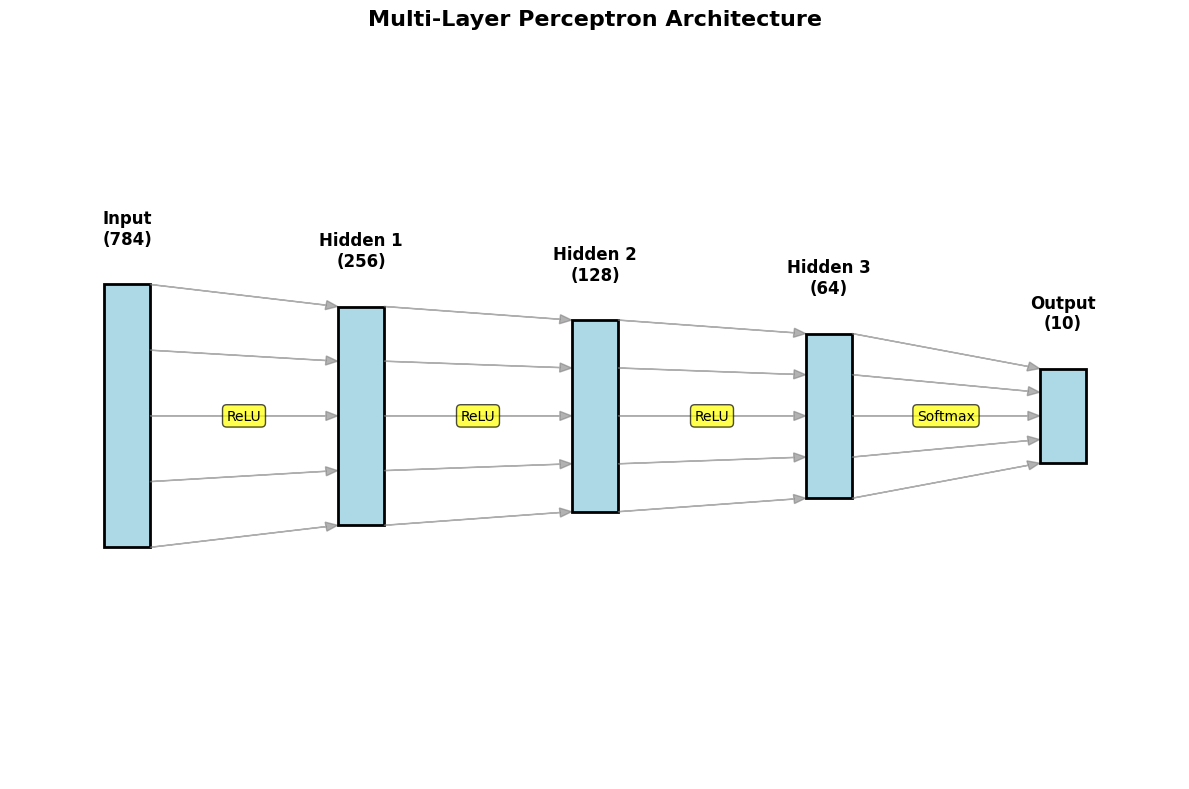

In [27]:
model.visualize()

In [28]:
#Sample Testing

with torch.no_grad():
    sample_input = torch.randn(32, 1, 28, 28).to(device)  # Batch of 32 random images
    output = model(sample_input)
    print(f"   Input shape: {sample_input.shape}")
    print(f"   Output shape: {output.shape}")
    print(f"   Output range: [{output.min():.3f}, {output.max():.3f}]")

    # Apply softmax to see probabilities
    probabilities = F.softmax(output, dim=1)
    print(f"   Probability range: [{probabilities.min():.3f}, {probabilities.max():.3f}]")
    print(f"   Probability sum per sample: {probabilities.sum(dim=1)[0]:.3f} (should be ~1.0)")

   Input shape: torch.Size([32, 1, 28, 28])
   Output shape: torch.Size([32, 10])
   Output range: [-0.260, 0.263]
   Probability range: [0.077, 0.133]
   Probability sum per sample: 1.000 (should be ~1.0)
